## **Problem Statement**
# Use Random Forest to prepare a model on fraud data 
## treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

## 0.1 Table of Contents<a class="anchor" id="0.1"></a>
1. [Introduction](#1)
2. [About Dataset](#2)
3. [Data Exploration](#3)
    - 3.1 [Descriptive Analysis](#3.1)
    - 3.2 [Feature Engineering](#3.2)
4. [Exploratory Data Analysis](#4)
    - 4.1 [Univariate plots](#4.1)
    - 4.2 [Multivariate plots](#4.2)
5. [Feature Selection Technique](#5)
    - 5.1 [Data Pre-Processing](#5.1)
    - 5.2 [Random Forest Built-in Feature Importance](#5.2)
    - 5.3 [Test Train Split With Imbalanced Dataset](#5.3)
6. [About Stratify](#6)
    - 6.1 [Grid search using Stratified Kfold Splits on Imbalanced Dataset](#6.1)
    - 6.2 [Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset](#6.2)
7. [Handling imbalance data using SMOTE based techniques](#7)
    - 7.1 [SMOTE Oversampling technique](#7.1)
    - 7.2 [ADASYN: Adaptive Synthetic Sampling Approach](#7.2)
    - 7.3 [Hybridization: SMOTE + Tomek Links](#7.3)
    - 7.4 [Hybridization: SMOTE + ENN](#7.4)
    - 7.5 [Performance Analysis after Resampling](#7.5)
8. [Random Forest](#8)
    - 8.1 [Random Forest hyperparameter tuning](#8.1)
        - - a) [Randomized Search Cross Validation](#a)
        - - b) [Grid Search Cross Validation](#b)
    - 8.2 [Visualizing one of the decision tree in random forest](#8.2)
9. [Applications of Random Forest](#9)
    - 9.1 [Advantages of Random Forest](#9.1)
    - 9.2 [Disadvantages of Random Forest](#9.2)
10. [Summary](#10)

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns


sns.set_style('darkgrid')
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

     ---------------------------------------- 9.9/9.9 MB 10.0 MB/s eta 0:00:00
     ------------------------------------- 325.2/325.2 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.8/1.8 MB 8.8 MB/s eta 0:00:00
     ---------------------------------------- 6.4/6.4 MB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.1/2.1 MB 10.4 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 10.6 MB/s eta 0:00:00
     -------------------------------------- 158.9/158.9 kB 9.3 MB/s eta 0:00:00
     ------------------------------------- 273.3/273.3 kB 17.5 MB/s eta 0:00:00
     -------------------------------------- 133.6/133.6 kB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\DELL\\anaconda3\\Lib\\site-packages\\~egex\\_regex.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



ModuleNotFoundError: No module named 'dataprep'

In [4]:
# Import Dataset
df = pd.read_csv("C:/Users/DELL/Downloads/assignment/Random_Forests/Fraud_check.csv")
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


## 2. About Dataset<a class="anchor" id="2"></a>
Context\
About the data: 

+ Undergrad : person is under graduated or not
+ Marital.Status : marital status of a person
+ Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
+ Work Experience : Work experience of an individual person
+ Urban : Whether that person belongs to urban area or not

[Table of Contents](#0.1)

## 3. Data Exploration <a class="anchor" id="3"></a>

Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

In [5]:
df.isnull().any()

Undergrad          False
Marital.Status     False
Taxable.Income     False
City.Population    False
Work.Experience    False
Urban              False
dtype: bool

In [6]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

- We have no missing data so all the entries are valid for use.

- Now we can check the column names to get a better understanding of what features we will be basing our classification on.

### 3.1 Descriptive Analysis<a class="anchor" id="3.1"></a>

In [7]:
df.shape

(600, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [9]:
df[df.duplicated()].shape

(0, 6)

In [10]:
df[df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [11]:
df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


The features are not on the same scale. For example `City.Population` has a mean of `108747.36` while `Work.Experience` has a mean value of `15.55`. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check further.

### 3.2 Feature Engineering<a class="anchor" id="3.2"></a>

[Table of Contents](#0.1)

### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [12]:
df['Taxable.Income'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: Taxable.Income, dtype: float64

In [13]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


C:\Users\DELL\AppData\Local\Temp\ipykernel_12624\1617629718.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})


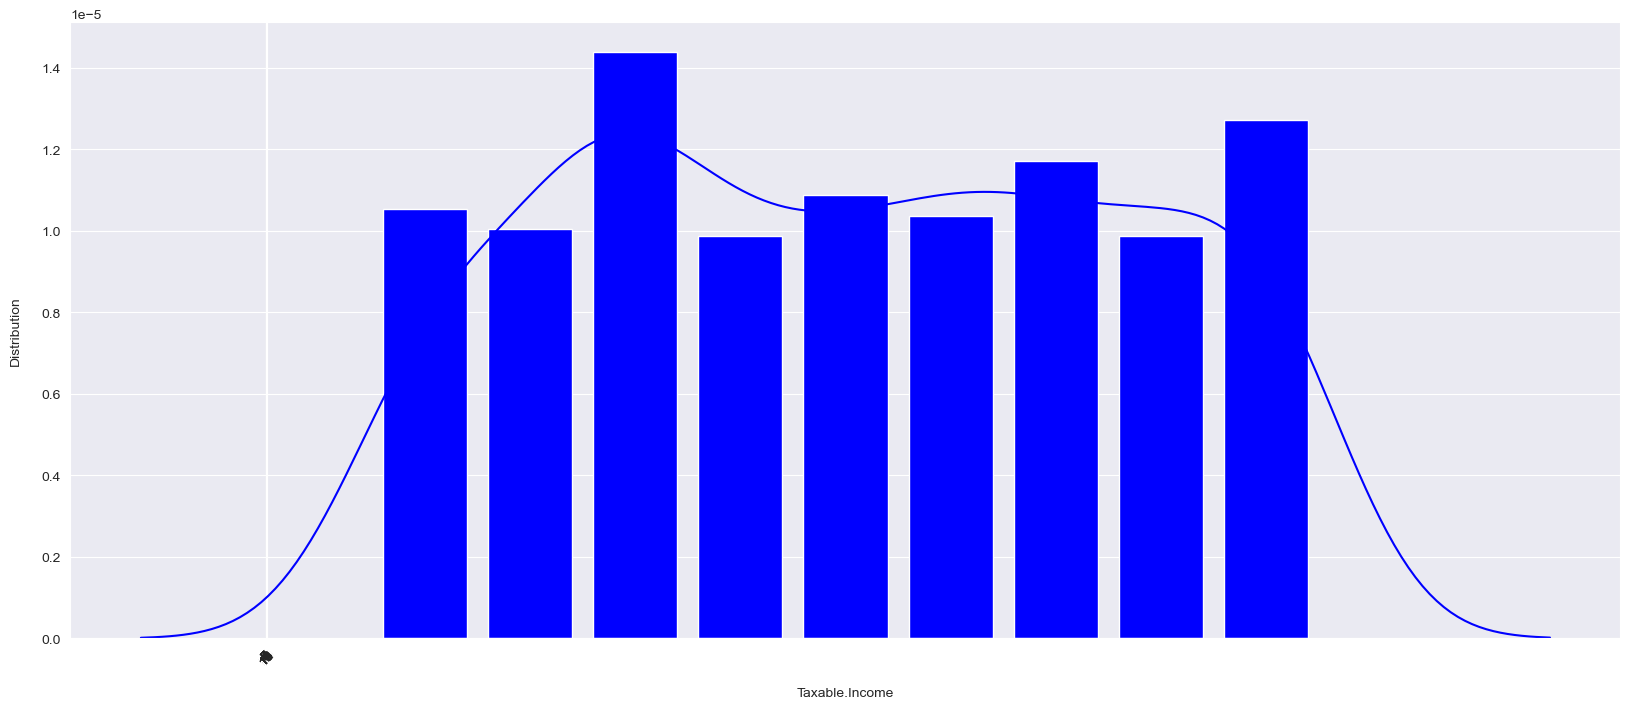

In [14]:
def distplot(param):
    plt.figure(figsize=(20,8))
    sns.distplot(df[param], color = "blue", hist_kws={"rwidth":0.80, 'alpha':1.0})
    plt.xticks(np.arange(0,20,1),rotation=45)
    plt.xlabel('\n'+param)
    plt.ylabel('Distribution\n')
    plt.show()
distplot("Taxable.Income")

In [15]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Undergrad         600 non-null    object  
 1   Marital.Status    600 non-null    object  
 2   Taxable.Income    600 non-null    int64   
 3   City.Population   600 non-null    int64   
 4   Work.Experience   600 non-null    int64   
 5   Urban             600 non-null    object  
 6   taxable_category  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [17]:
categorical_features = df1.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')

In [18]:
numerical_features = df1.describe(include=["int64","float64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

## 4. Data Visualization<a class="anchor" id="4"></a>

[Table of Contents](#0.1)

+ ###  Univariate plots<a class="anchor" id="4.1"></a>

Next let's get the distribution of animal data across the types of classes.

C:\Users\DELL\AppData\Local\Temp\ipykernel_12624\959258083.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)


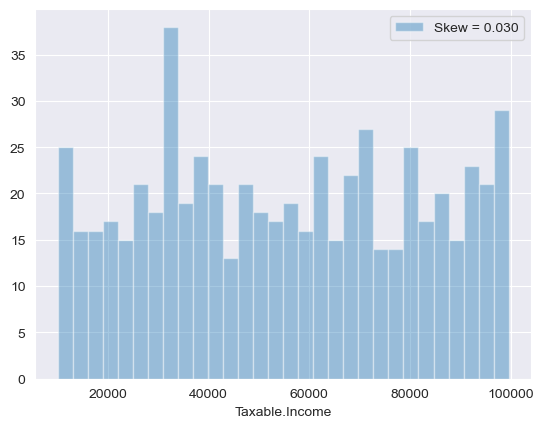

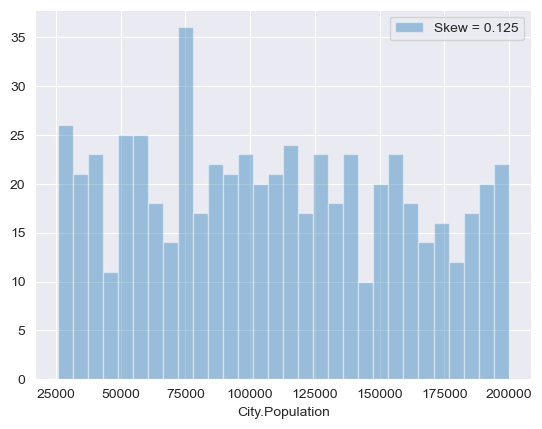

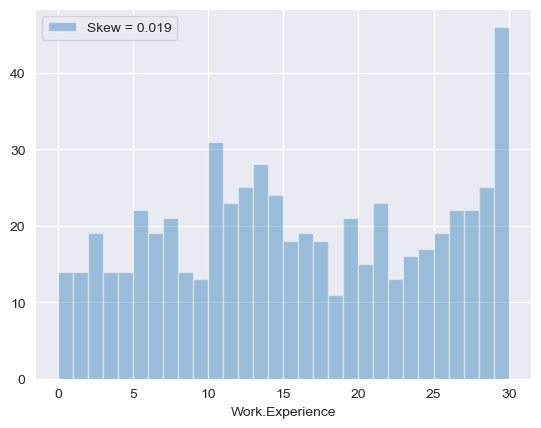

In [19]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

None of the features is normally distributed. The features Fe, Ba, Ca and K exhibit the highest skew coefficients. Moreover, the distribution of potassium (K) and Barium (Ba) seem to contain many outliers. Let's identify the indices of the observations containing outliers using Turkey's method.

In [20]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 0 observations with more than 2 outliers


##### Mmm hmm! there exists no observations with multiple outliers. 

Let's examine the boxplots for the several distributions

In [21]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

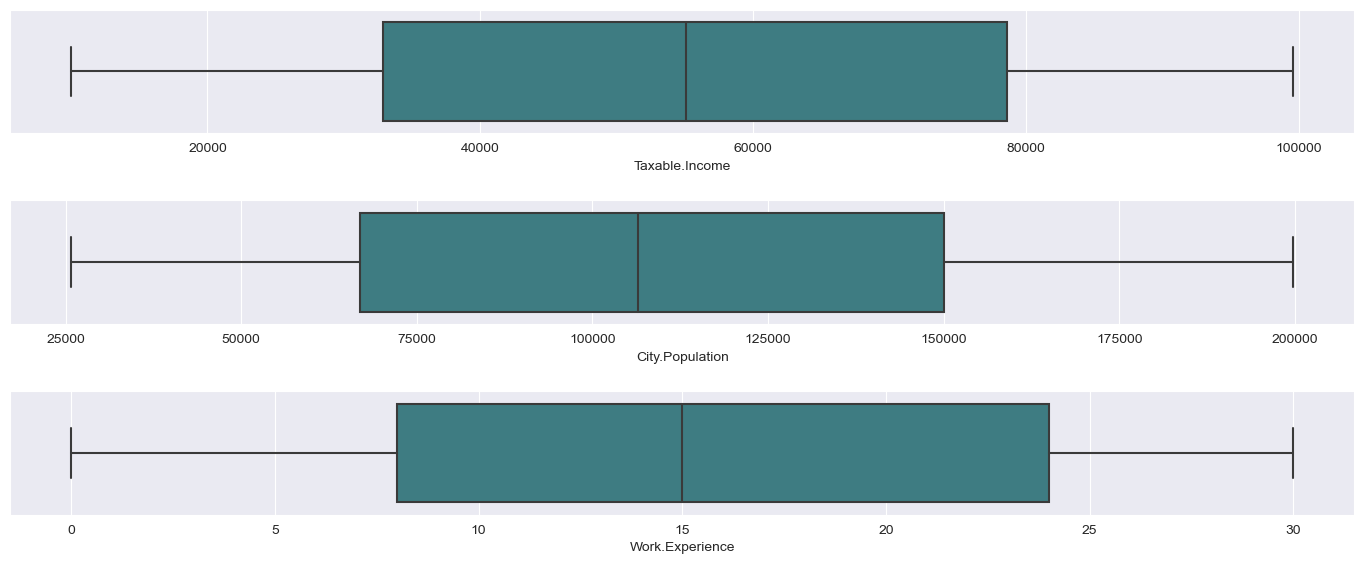

In [22]:
ot=df.copy() 
fig, axes=plt.subplots(3,1,figsize=(14,6),sharex=False,sharey=False)
sns.boxplot(x='Taxable.Income',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.tight_layout(pad=2.0)

<Axes: >

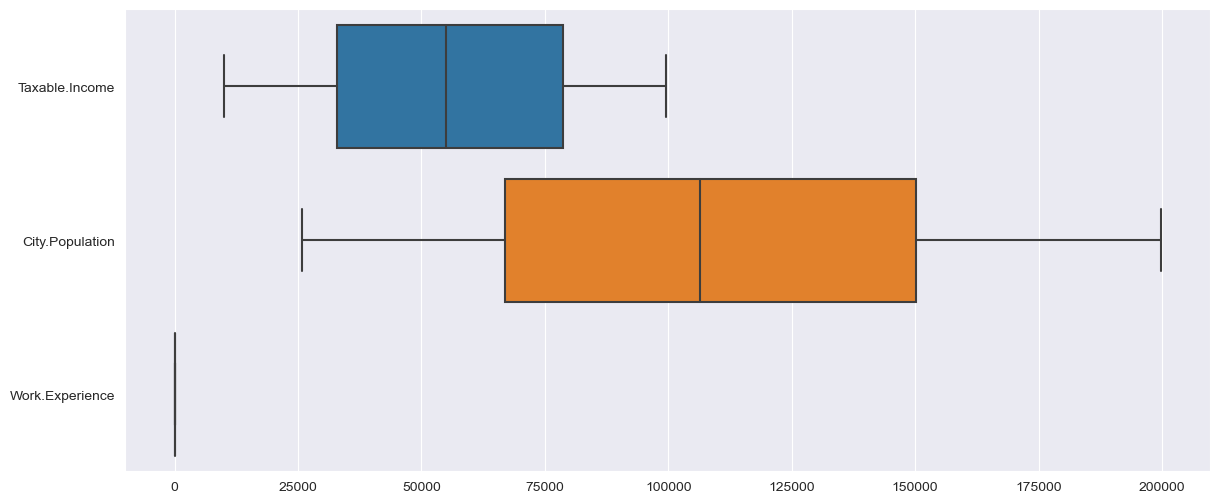

In [23]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h")

#### Unsurprisingly, **`Work.Experience`** has a mean that is much inferior to the other constituents as we already saw in the previous section.

[Table of Contents](#0.1)

+ ### Multivariate Analysis<a class="anchor" id="4.2"></a>


Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable

<Figure size 800x800 with 0 Axes>

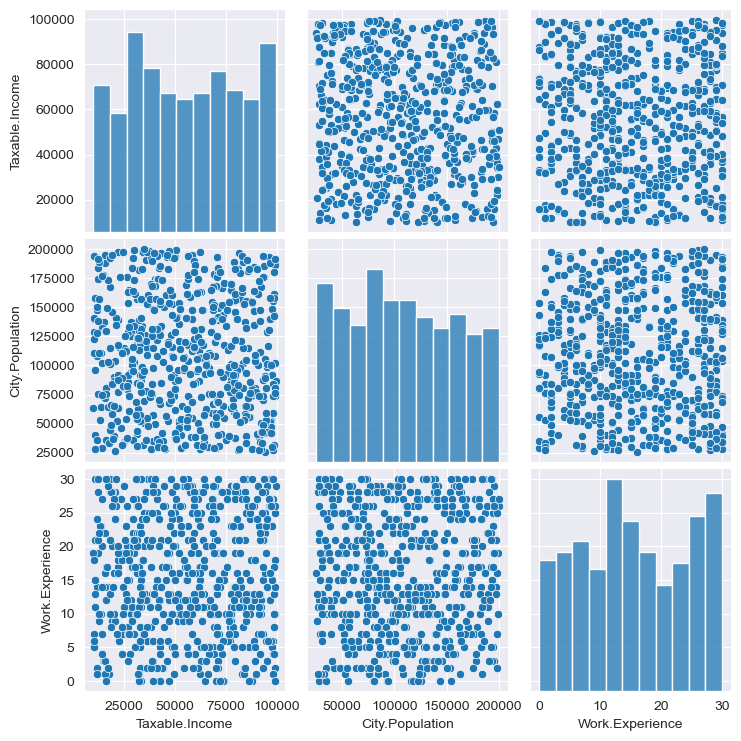

In [24]:
plt.figure(figsize=(8,8))
sns.pairplot(df, palette='coolwarm')
plt.show()

***Pearson's Correlation Coefficient***: helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson's Correlation Coefficient can be between -1 to +1. 1 means that they are highly correlated and 0 means no correlation.

A heat map is a two-dimensional representation of information with the help of colors. Heat maps can help the user visualize simple or complex information.

C:\Users\DELL\AppData\Local\Temp\ipykernel_12624\1960350118.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')


<Axes: >

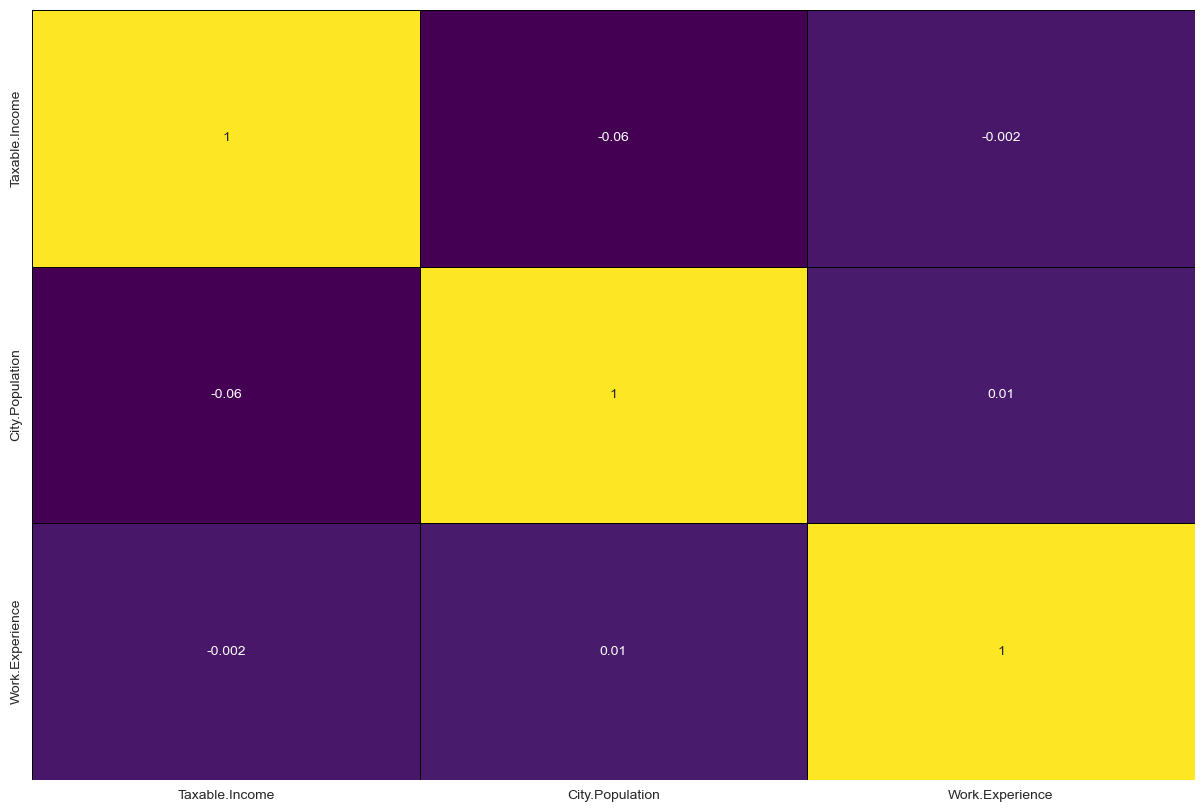

In [25]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban', 'taxable_category'], dtype='object')


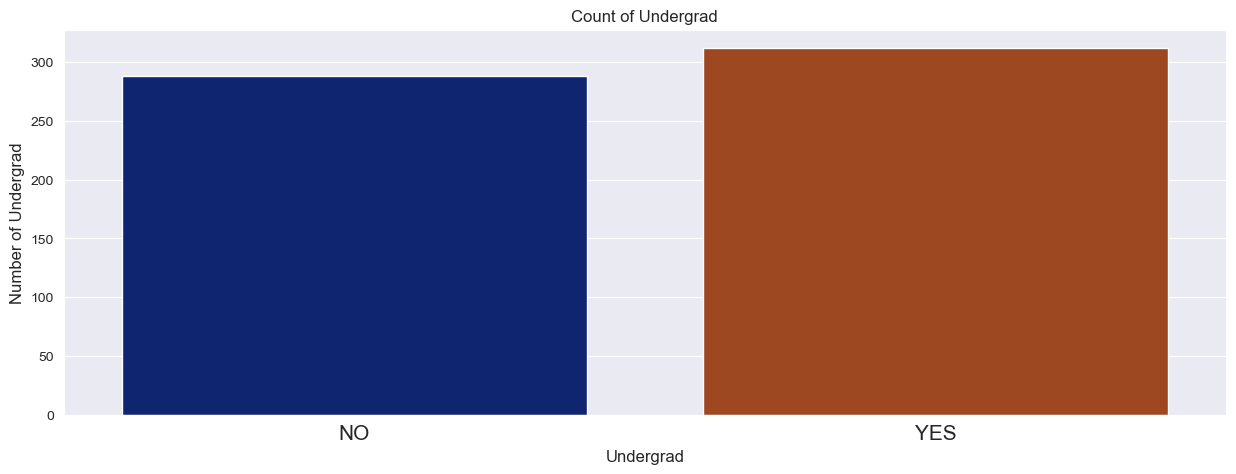

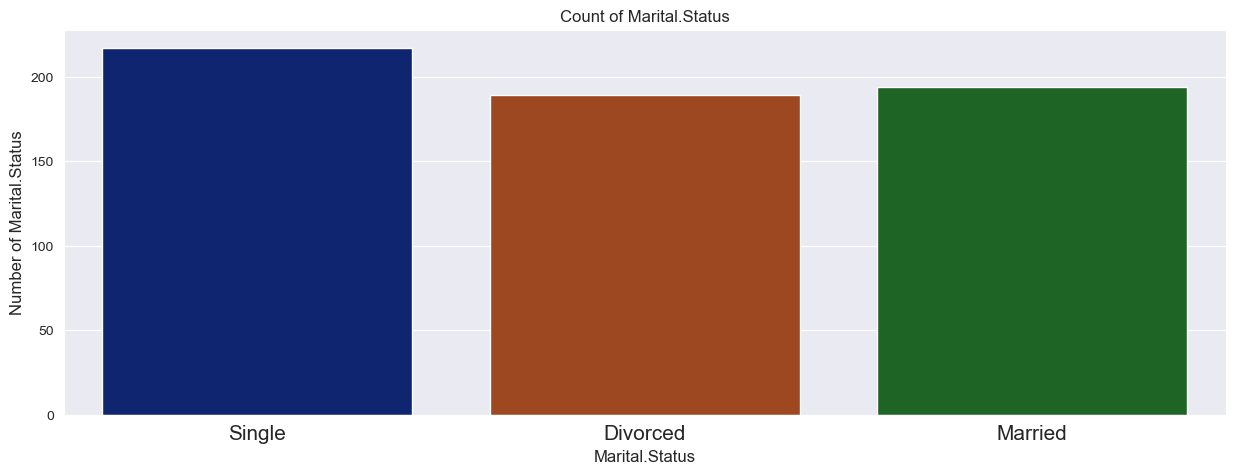

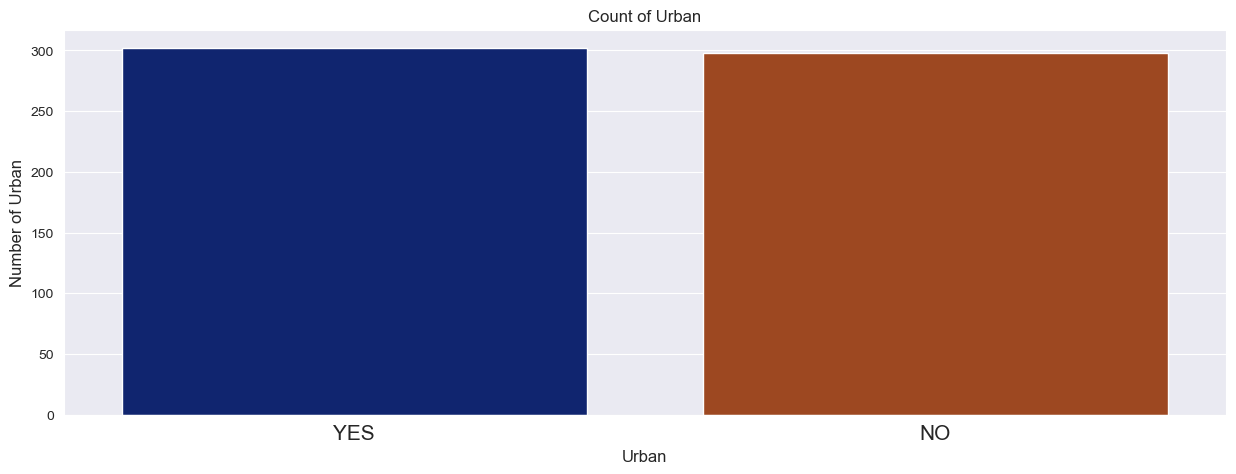

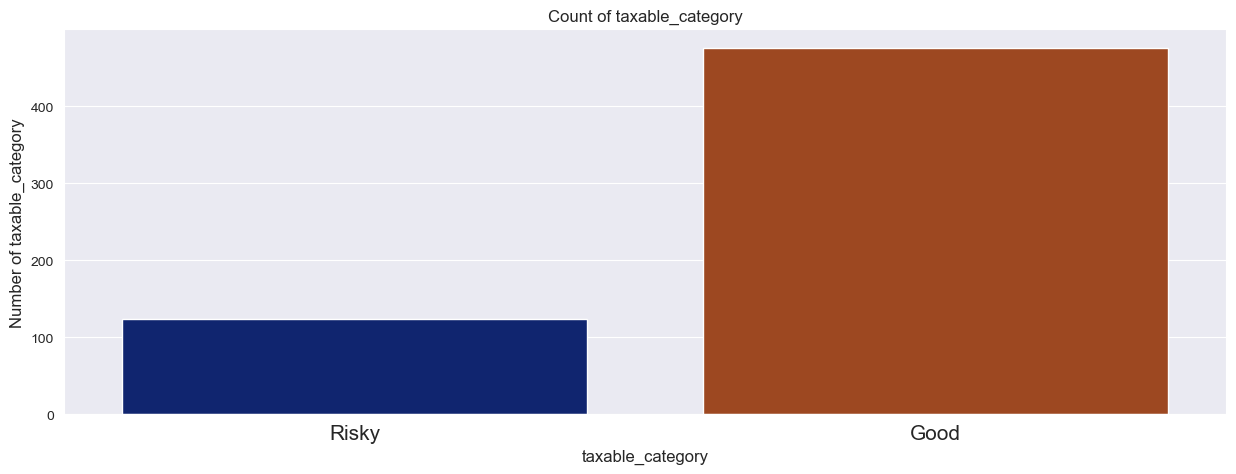

In [26]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df1[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df1, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

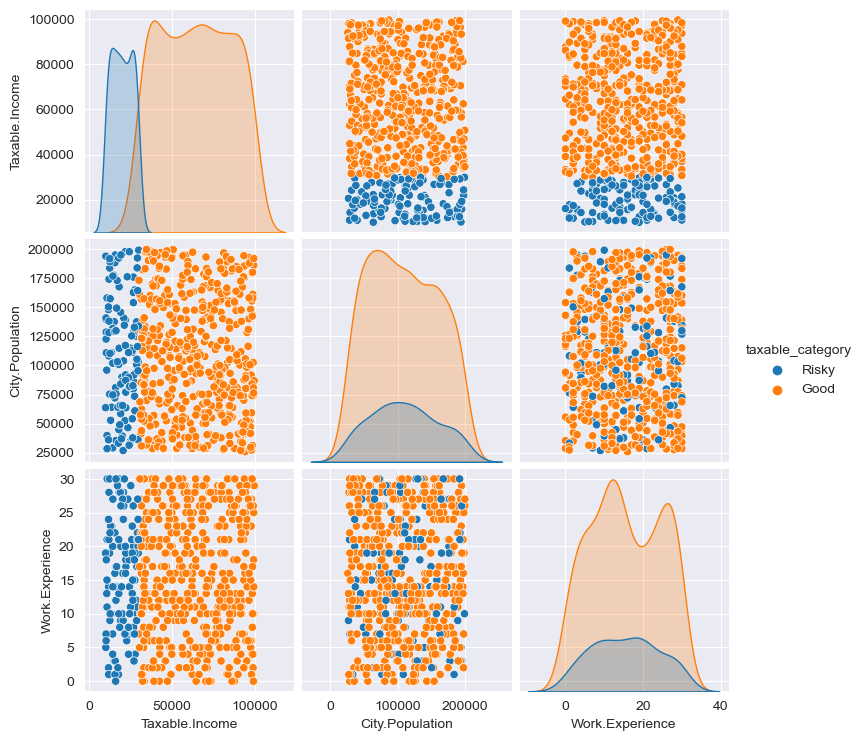

In [27]:
# let's plot pair plot to visualise the attributes all at once
import seaborn as sns
sns.pairplot(data=df1, hue = 'taxable_category')

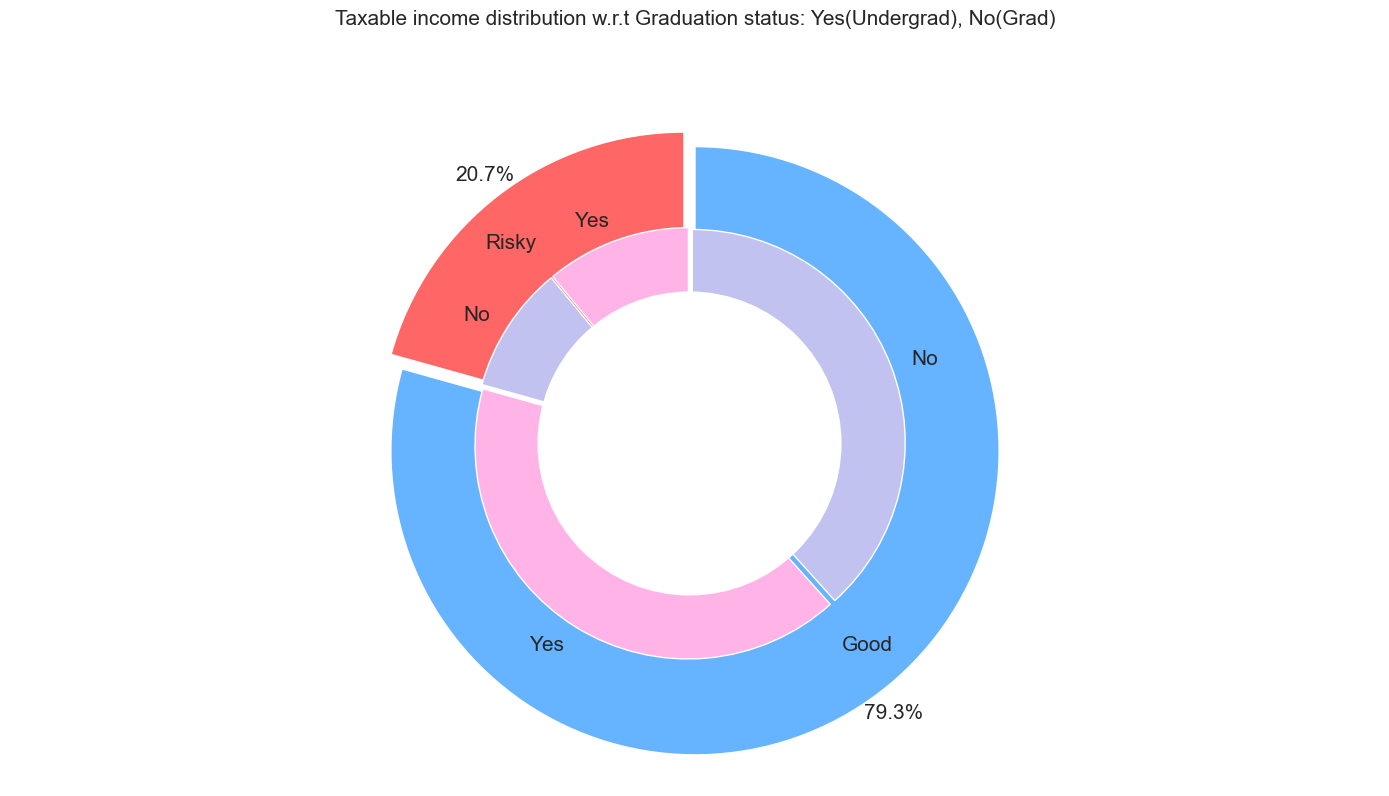

In [28]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Undergrad).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Undergrad).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [66,58 , 246,230]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Graduation status: Yes(Undergrad), No(Grad)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

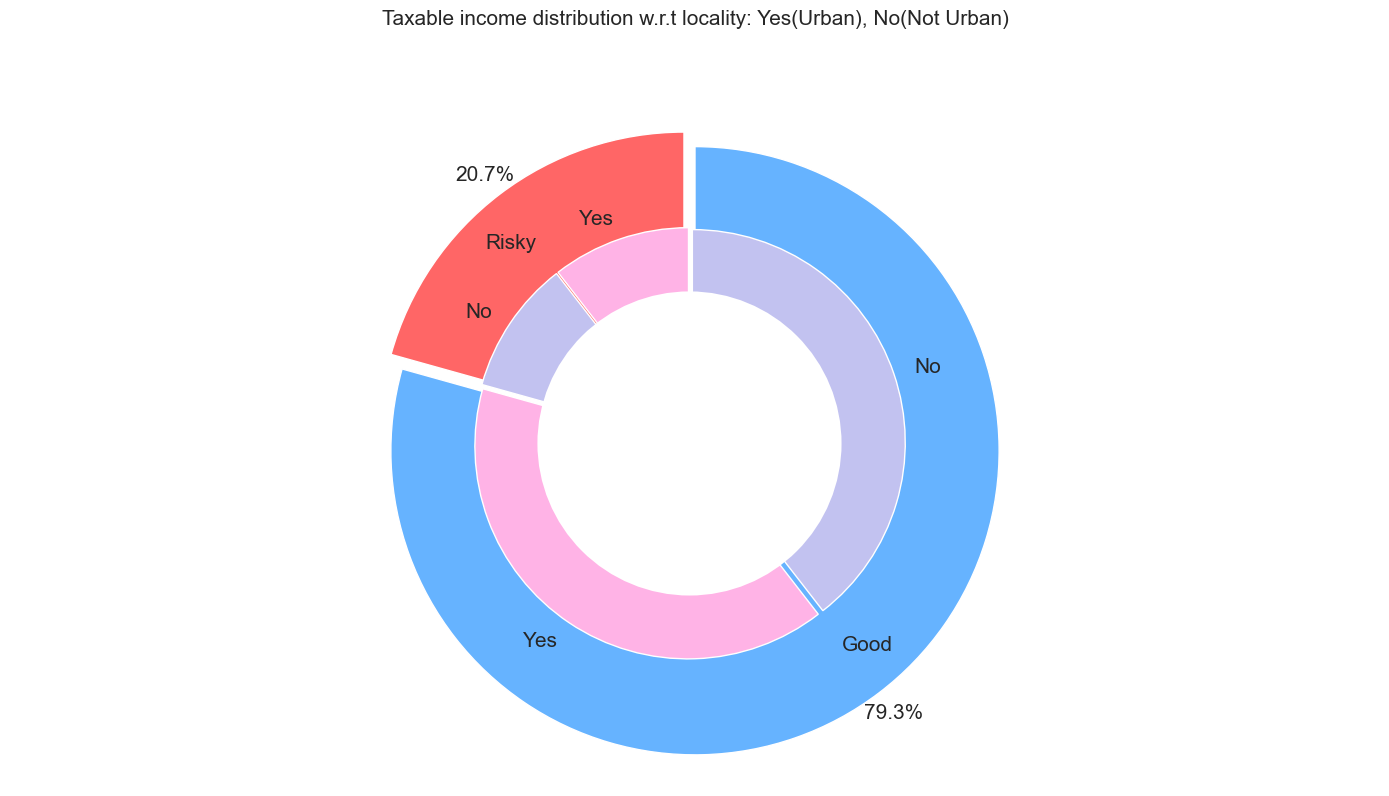

In [29]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1.Urban).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1.Urban).count().sum()]
labels_gender = ["Yes","No","Yes","No"]
sizes_gender = [63,61 , 239,237]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#ffb3e6', '#c2c2f0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t locality: Yes(Urban), No(Not Urban)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

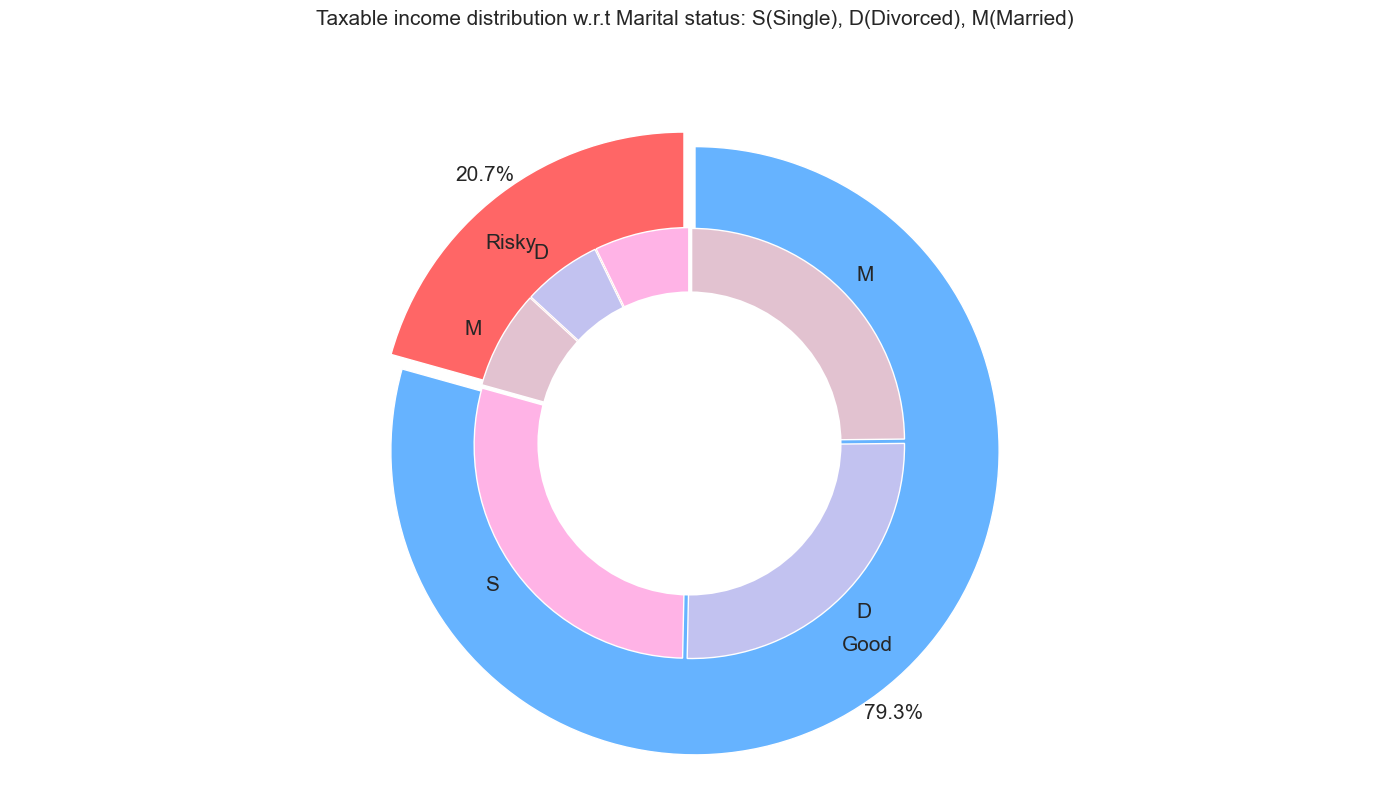

In [30]:
plt.figure(figsize=(14, 8))
labels =["Risky", "Good"]
values = [df1["taxable_category"][df1["taxable_category"] == 'Risky'].groupby(by = df1["Marital.Status"]).count().sum(),
         df1["taxable_category"][df1["taxable_category"] == 'Good'].groupby(by = df1["Marital.Status"]).count().sum()]
labels_gender = ["","D","M","S","D", "M"]
sizes_gender = [43,36,45,174,153,149]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#ffb3e6','#c2c2f0','#e2c2d0','#ffb3e6', '#c2c2f0', '#e2c2d0']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Taxable income distribution w.r.t Marital status: S(Single), D(Divorced), M(Married)', fontsize=15, y=1.1)

# show plot 
 
plt.axis('equal')
plt.tight_layout()
plt.show()

In [31]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


Text(0.5, 1.0, 'Correlation with Sales \n')

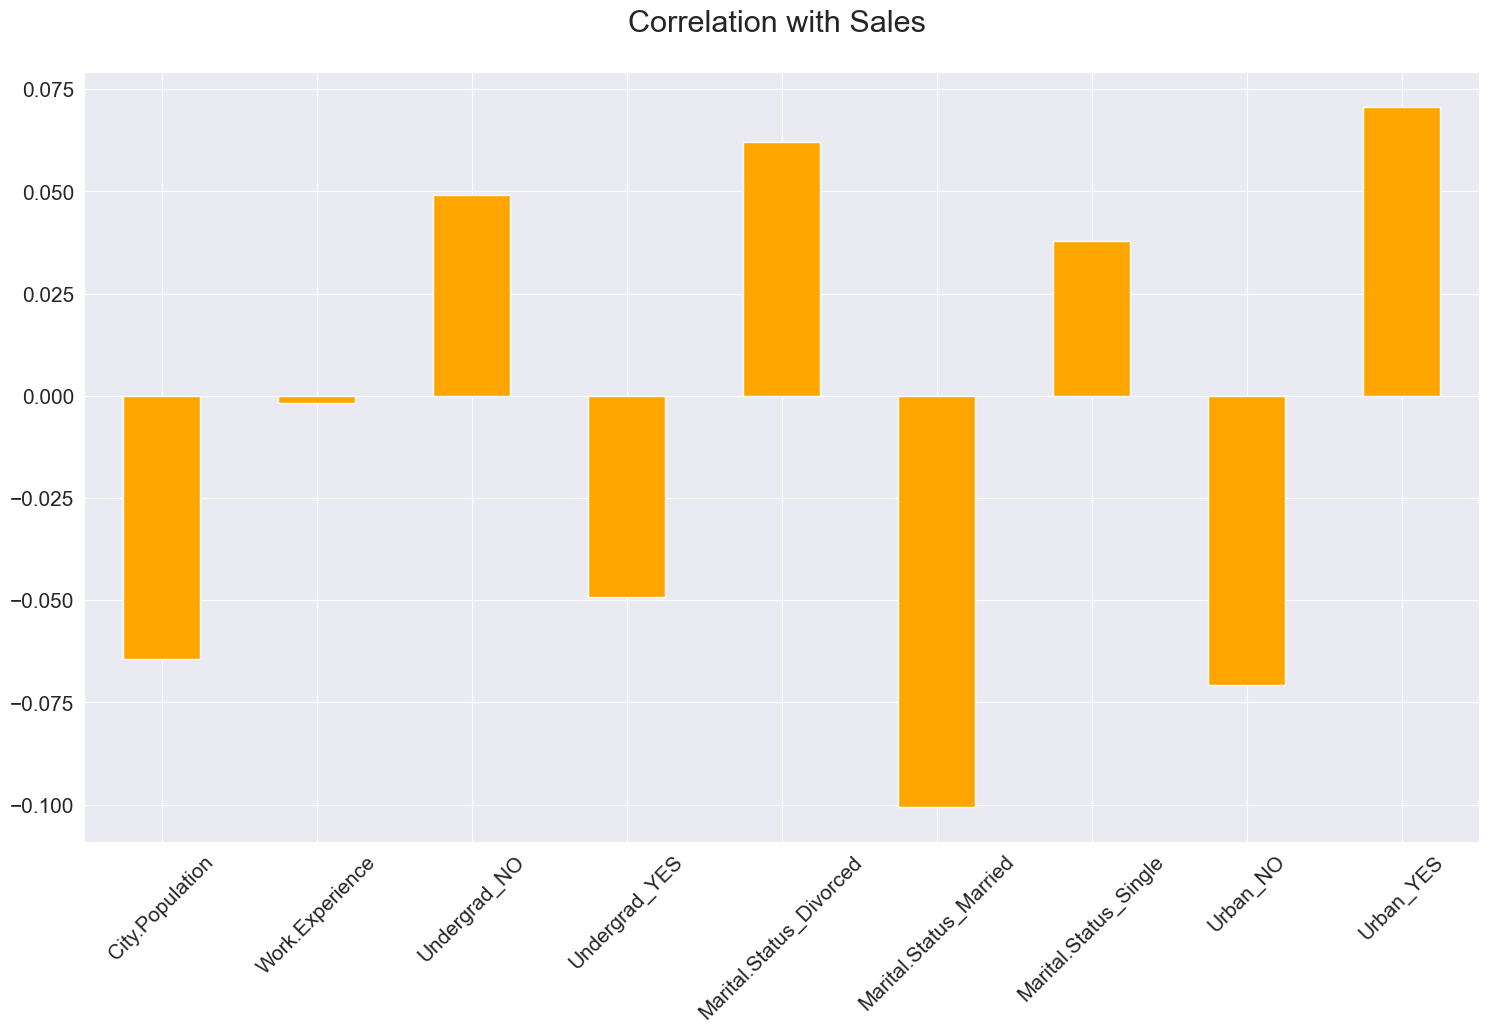

In [32]:
data2 = data_.copy()

correlations = data2.corrwith(df1['Taxable.Income'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Sales \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

#### Checking for Imbalanced or balanced dataset with regards to the Target

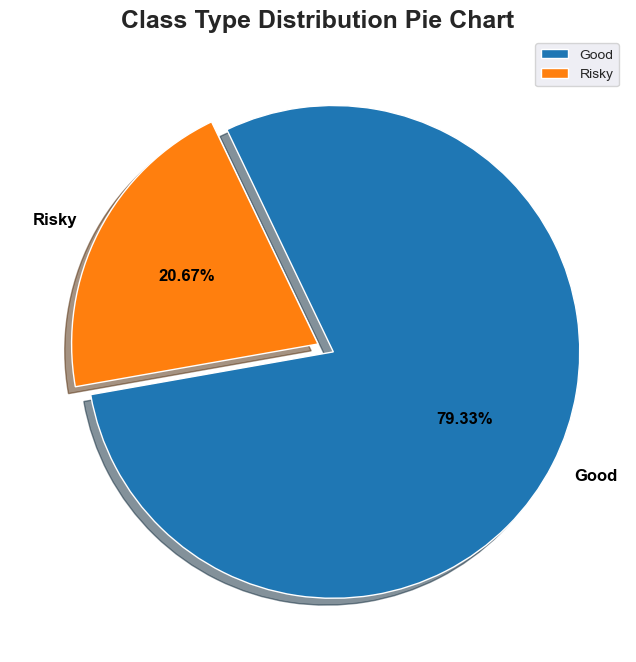

In [34]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()


##### Imbalanced data refers to those types of datasets where the target class has an uneven distribution of observations, i.e one class label has a very high number of observations and the other has a very low number of observations.

Here, the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [35]:
countNotermdeposit = len(df1[df1['taxable_category'] == 'Good'])
counthavetermdeposit = len(df1[df1['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df1.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df1.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [36]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

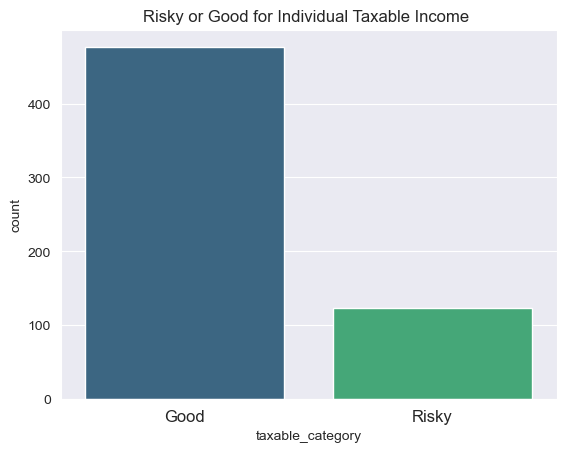

In [37]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

### Problems with imbalanced data classification
If we explain it in a very simple manner, the main problem with imbalanced dataset prediction is how accurately are we actually predicting both majority and minority class?

Sometimes when the records of a certain class are much more than the other class, our classifier may get biased towards the prediction. In this case, the confusion matrix for the classification problem shows how well our model classifies the target classes and we arrive at the accuracy of the model from the confusion matrix.

It is calculated based on the total no of correct predictions by the model divided by the total no of predictions. In the an example case it is (0+95)/(0+95+0+5)=0.95 or 95%. It means that the model fails to identify the minority class yet the accuracy score of the model will be 95%

Thus our traditional approach of classification and model accuracy calculation is not useful in the case of the imbalanced dataset

[Table of Contents](#0.1)

## 5. Feature Selection Technique<a class="anchor" id="5"></a>

### 5.1. Data Pre-Processing<a class="anchor" id="5.1"></a>

In [38]:
model_data = df1.copy()
model_data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
model_data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = model_data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [39]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(model_data[col])
        model_data[col] = le.transform(model_data[col])
model_data.head()

NameError: name 'LabelEncoder' is not defined

### Data Pre-processing for feature Selection

In [40]:
data_ = df1.copy()
data_.drop('Taxable.Income',axis=1, inplace =True)
data_ = pd.get_dummies(data_.iloc[:,:-1])
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES
0,50047,10,1,0,0,0,1,0,1
1,134075,18,0,1,1,0,0,0,1
2,160205,30,1,0,0,1,0,0,1
3,193264,15,0,1,0,0,1,0,1
4,27533,28,1,0,0,1,0,1,0


In [41]:
data_['Taxable_Income'] = df1.taxable_category
data_.head()

,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,Good
1,134075,18,0,1,1,0,0,0,1,Good
2,160205,30,1,0,0,1,0,0,1,Good
3,193264,15,0,1,0,0,1,0,1,Good
4,27533,28,1,0,0,1,0,1,0,Good


In [46]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data_["Taxable_Income"])
data_["Taxable_Income"]=le.transform(data_["Taxable_Income"])
data_.head()


,City.Population,Work.Experience,Undergrad_NO,Undergrad_YES,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Urban_NO,Urban_YES,Taxable_Income
0,50047,10,1,0,0,0,1,0,1,0
1,134075,18,0,1,1,0,0,0,1,0
2,160205,30,1,0,0,1,0,0,1,0
3,193264,15,0,1,0,0,1,0,1,0
4,27533,28,1,0,0,1,0,1,0,0


In [47]:
# split into input (X) and output (y) variables
X = data_.iloc[:, :-1]

y=  data_.Taxable_Income

In [48]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2

In [49]:
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

In [50]:
# summarize scores
scores = fit.scores_

features = fit.transform(X)

In [51]:
score_df = pd.DataFrame(list(zip(scores, X.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

,Score,Feature
0,2045.643886,City.Population
5,0.756912,Marital.Status_Married
4,0.302172,Marital.Status_Divorced
6,0.095850,Marital.Status_Single
2,0.048929,Undergrad_NO
3,0.045165,Undergrad_YES
1,0.011709,Work.Experience
7,0.007044,Urban_NO
8,0.006951,Urban_YES


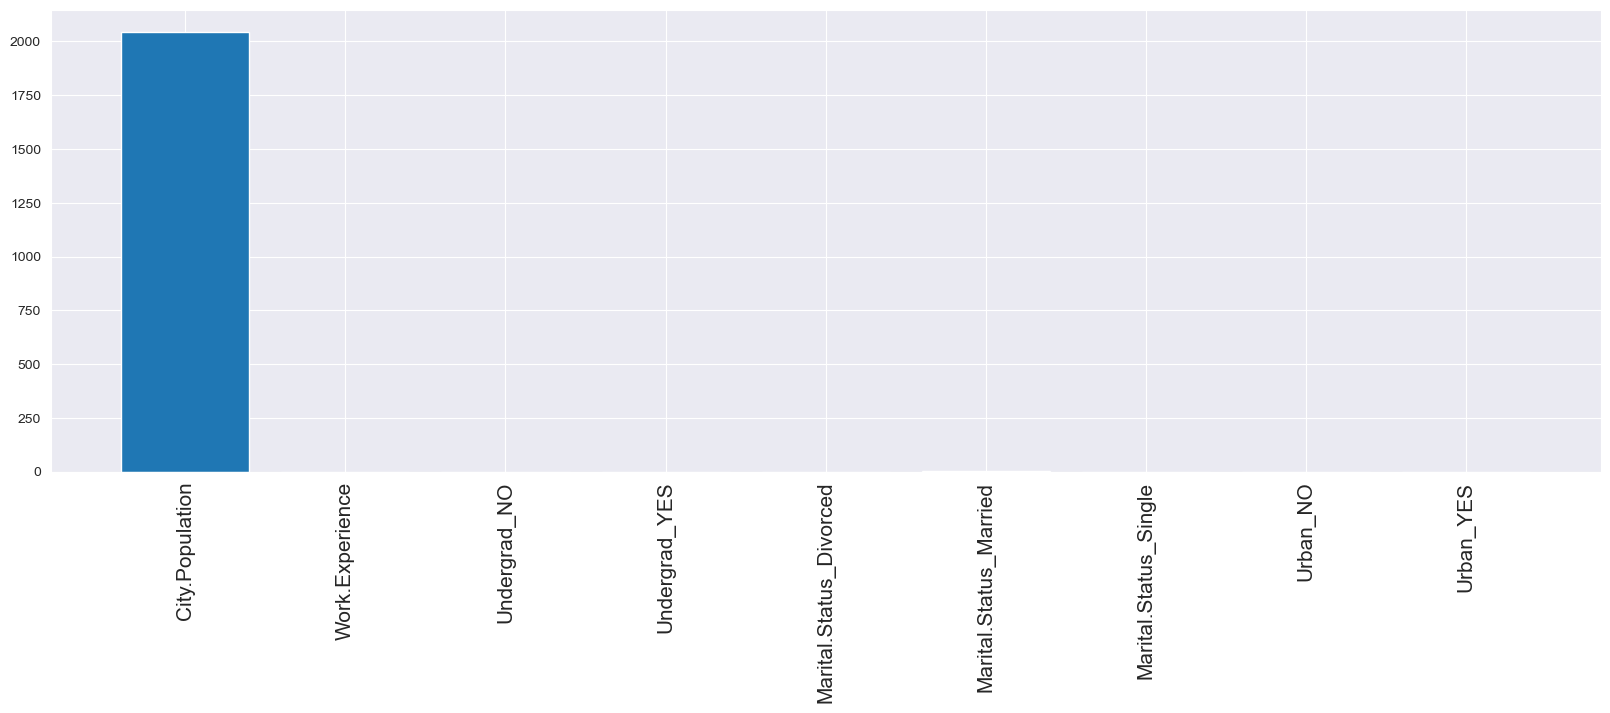

In [52]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8])
axes.set_xticklabels(X.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

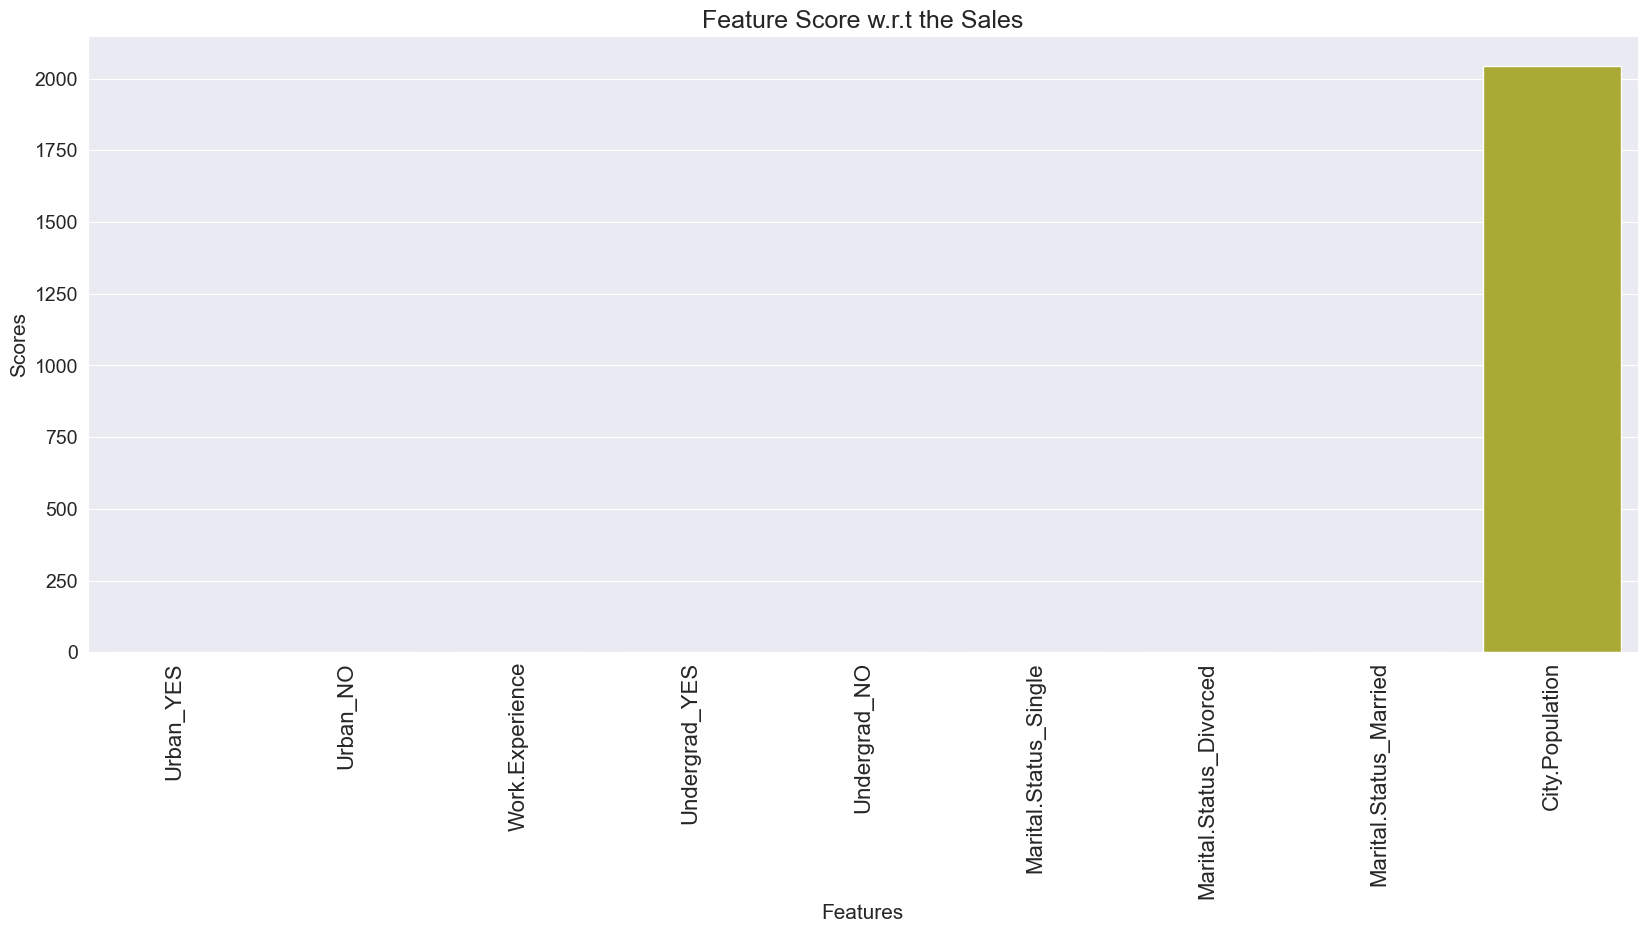

In [53]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

### 5.2 Random Forest Built-in Feature Importance<a class="anchor" id="5.2"></a>
The Random Forest algorithm has built-in feature importance which can be computed in two ways:

+ **Gini importance** (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. <mark>**It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within.**</mark> The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance. This method is available in scikit-learn implementation of the Random Forest (for both classifier and regressor). It is worth to mention, that in this method we should look at relative values of the computed importances. This biggest advantage of this method is a speed of computation - all needed values are computed during the Radom Forest training. The drawbacks of the method is to tendency to prefer (select as important) numerical features and categorical features with high cardinality. What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).

+ **Mean Decrease Accuracy** - is a method of computing the feature importance on permuted out-of-bag (OOB) samples based on mean decrease in the accuracy. This method is not implemented in the scikit-learn package. The very similar to this method is permutation based importance described below in this post.

In [55]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,n_estimators=100, oob_score=True)
classifier_rf.fit(X, y)

# checking the oob score
print('checking the oob score',classifier_rf.oob_score_)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X, y)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)


checking the oob score 0.7933333333333333
Fitting 4 folds for each of 180 candidates, totalling 720 fits
Best Score 0.7933333333333333
RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)


#### Now let’s sort the data with the help of feature importance

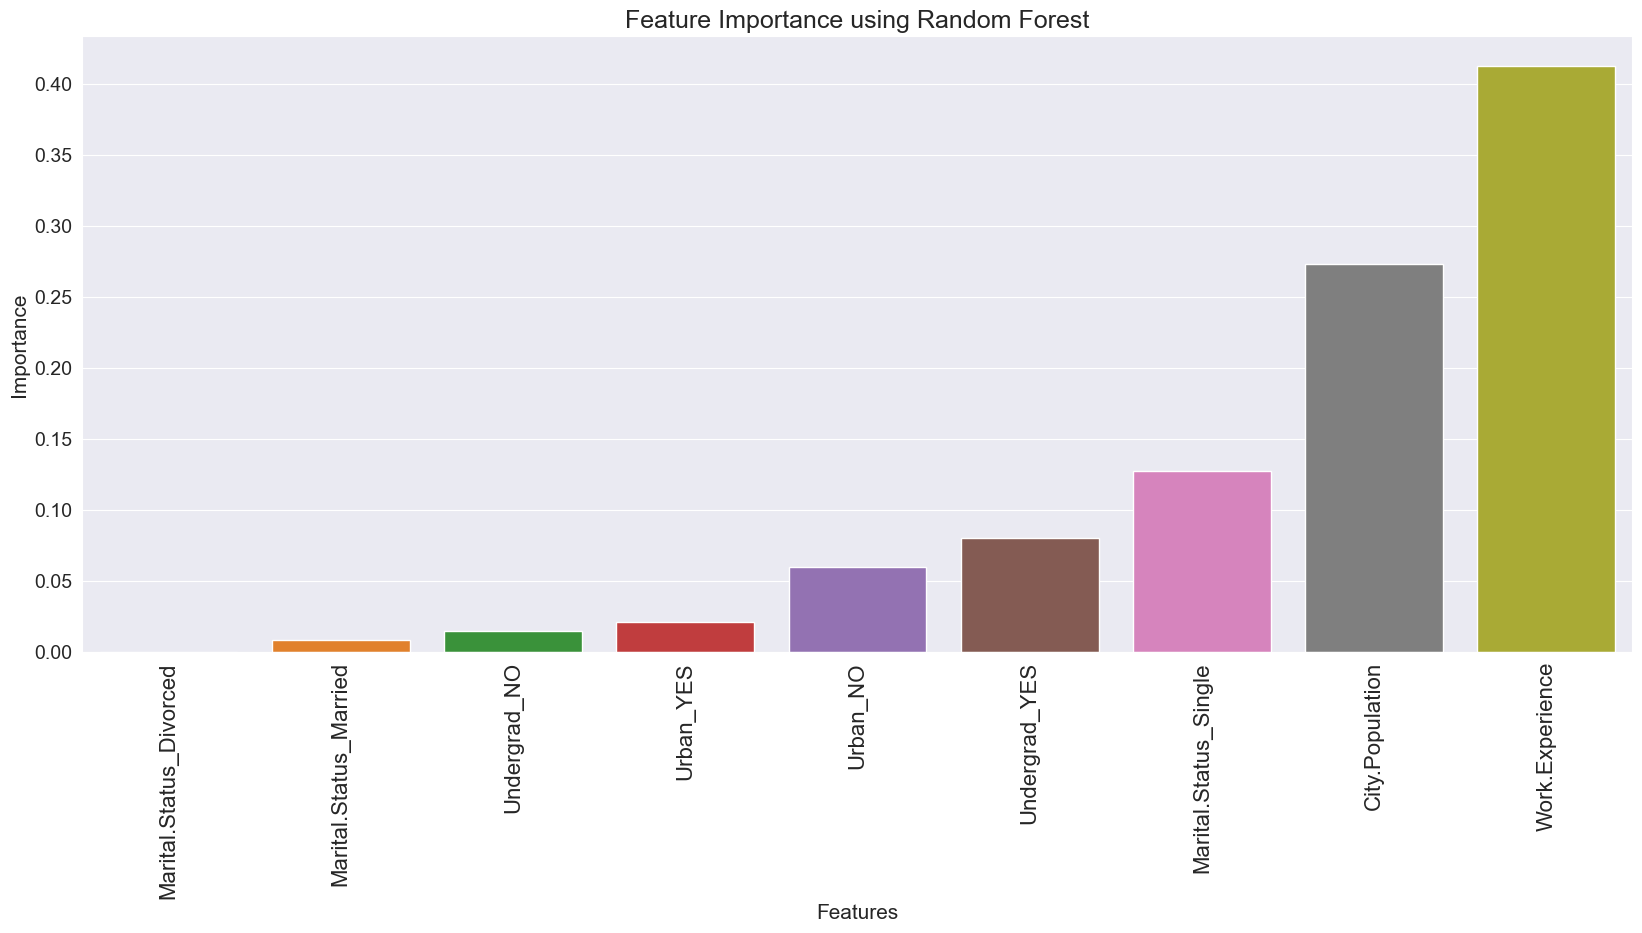

In [56]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Importance", 
            data=imp_df, 
            order=imp_df.sort_values('Importance').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Importance", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Importance using Random Forest", size=18)
plt.show()

[Table of Contents](#0.1)

### 5.3 Test Train Split With Imbalanced Dataset<a class="anchor" id="5.3"></a>



***Train Test Split*** : To have unknown datapoints to test the data rather than testing with the same points with which the model was trained. This helps capture the model performance much better.

![](https://cdn-images-1.medium.com/max/1600/1*-8_kogvwmL1H6ooN1A1tsQ.png)

***Cross Validation***: When model is split into training and testing it can be possible that specific type of data point may go entirely into either training or testing portion. This would lead the model to perform poorly. Hence over-fitting and underfitting problems can be well avoided with cross validation techniques

![](https://cdn-images-1.medium.com/max/1600/1*4G__SV580CxFj78o9yUXuQ.png)



In [57]:
model_data.columns

Index(['Undergrad', 'Marital_Status', 'City_Population', 'Work_Experience',
       'Urban', 'taxable_category'],
      dtype='object')

In [58]:
x = model_data.drop('taxable_category',axis=1)
y = model_data['taxable_category']

In [59]:
y.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

In [61]:
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
    # select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
    # summarize train and test composition
    counter_train = Counter(train_y)
    counter_test = Counter(test_y)
    print('Training Data',counter_train,'Testing Data',counter_test)


Training Data Counter({'Good': 428, 'Risky': 112}) Testing Data Counter({'Good': 48, 'Risky': 12})
Training Data Counter({'Good': 428, 'Risky': 112}) Testing Data Counter({'Good': 48, 'Risky': 12})
Training Data Counter({'Good': 428, 'Risky': 112}) Testing Data Counter({'Good': 48, 'Risky': 12})
Training Data Counter({'Good': 428, 'Risky': 112}) Testing Data Counter({'Good': 48, 'Risky': 12})
Training Data Counter({'Good': 428, 'Risky': 112}) Testing Data Counter({'Good': 48, 'Risky': 12})
Training Data Counter({'Good': 428, 'Risky': 112}) Testing Data Counter({'Good': 48, 'Risky': 12})
Training Data Counter({'Good': 429, 'Risky': 111}) Testing Data Counter({'Good': 47, 'Risky': 13})
Training Data Counter({'Good': 429, 'Risky': 111}) Testing Data Counter({'Good': 47, 'Risky': 13})
Training Data Counter({'Good': 429, 'Risky': 111}) Testing Data Counter({'Good': 47, 'Risky': 13})
Training Data Counter({'Good': 429, 'Risky': 111}) Testing Data Counter({'Good': 47, 'Risky': 13})


In [65]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)


In [66]:
# summarize train and test composition
counter_train = Counter(y_train)
counter_test = Counter(y_test)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({'Good': 333, 'Risky': 87}) Testing Data Counter({'Good': 143, 'Risky': 37})


In [67]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


## 6. ***About Stratify*** :<a class="anchor" id="6"></a> 
+ Stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.

For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.

In machine learning, When we want to train our ML model we split our entire dataset into training_set and test_set using train_test_split() class present in sklearn. Then we train our model on training_set and test our model on test_set. The problems that we are going to face in this method are:

Whenever we change the random_state parameter present in train_test_split(), We get different accuracy for different random_state and hence we can’t exactly point out the accuracy for our model. 
The train_test_split() splits the dataset into training_test and test_set by random sampling. But stratified sampling is performed.

What are random sampling and Stratified sampling? 
Suppose you want to take a survey and decided to call 1000 people from a particular state, If you pick either 1000 males completely or 1000 females completely or 900 females and 100 males (randomly) to ask their opinion on a particular product. Then based on these 1000 opinions you can’t decide the opinion of that entire state on your product. This is random sampling.
But in Stratified Sampling, Let the population for that state be 51.3% male and 48.7% female, Then for choosing 1000 people from that state if you pick 513 male ( 51.3% of 1000 ) and 487 female ( 48.7% for 1000 ) i.e 513 male + 487 female (Total=1000 people) to ask their opinion. Then these groups of people represent the entire state. This is called Stratified Sampling.

Why random sampling is not preferred in machine learning? 
Let’s consider a binary-class classification problem. Let our dataset consists of 100 samples out of which 80 are negative class { 0 } and 20 are positive class { 1 }.

Random sampling: 
If we do random sampling to split the dataset into training_set and test_set in an 8:2 ratio respectively.Then we might get all negative class {0} in training_set i.e 80 samples in training_test and all 20 positive class {1} in test_set.Now if we train our model on training_set and test our model on test_set, Then obviously we will get a bad accuracy score.

Stratified Sampling: 
In stratified sampling, The training_set consists of 64 negative class{0} ( 80% 0f 80 ) and 16 positive class {1} ( 80% of 20 ) i.e. 64{0}+16{1}=80 samples in training_set which represents the original dataset in equal proportion and similarly test_set consists of 16 negative class {0} ( 20% of 80 ) and 4 positive class{1} ( 20% of 20 ) i.e. 16{0}+4{1}=20 samples in test_set which also represents the entire dataset in equal proportion.This type of train-test-split results in good accuracy.

What is the solution to mentioned problems? 
The solution for the first problem where we were able to get different accuracy scores for different random_state parameter values is to use K-Fold Cross-Validation. But K-Fold Cross Validation also suffers from the second problem i.e. random sampling.
The solution for both the first and second problems is to use Stratified K-Fold Cross-Validation.

What is Stratified K-Fold Cross Validation? 
Stratified k-fold cross-validation is the same as just k-fold cross-validation, But Stratified k-fold cross-validation, it does stratified sampling instead of random sampling.

For Reference : https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

[Table of Contents](#0.1)

### 6.1. Grid search using Stratified Kfold Splits on Imbalanced Dataset<a class="anchor" id="6.1"></a> 

In [111]:

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to 'Taxable.Income'
data_['Taxable_Income'] = le.fit_transform(data_['Taxable_Income'])

# Now, 'Taxable.Income' is in numerical format



In [112]:
data_.columns



Index(['City.Population', 'Work.Experience', 'Undergrad_NO', 'Undergrad_YES',
       'Marital.Status_Divorced', 'Marital.Status_Married',
       'Marital.Status_Single', 'Urban_NO', 'Urban_YES', 'Taxable_Income'],
      dtype='object')

In [113]:
# Step 2: Handle Missing Values (Imputation)
# Assuming 'Taxable_Income' has missing values
data_['Taxable_Income'].fillna(data_['Taxable_Income'].mean(), inplace=True)

# Step 3: Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

X = data_.drop('Taxable_Income', axis=1)
y = data_['Taxable_Income']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)

# Step 5: Evaluate the Model
from sklearn.metrics import accuracy_score

train_preds = rf_clf.predict(train_X)
test_preds = rf_clf.predict(test_X)

train_accuracy = accuracy_score(train_y, train_preds)
test_accuracy = accuracy_score(test_y, test_preds)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')


Training Accuracy: 1.0
Testing Accuracy: 0.7333333333333333


In [114]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(train_X, train_y)


RandomForestClassifier()

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}\n")



In [116]:

print_score(rf_clf, train_X, train_y, test_X, test_y, train=True)
print_score(rf_clf, train_X, train_y, test_X, test_y, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       382
           1       1.00      1.00      1.00        98

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

_______________________________________________
Confusion Matrix:
 [[382   0]
 [  0  98]]

Test Result:
Accuracy Score: 73.33%
_______________________________________________
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        94
           1       0.00      0.00      0.00        26

    accuracy                           0.73       120
   macro avg       0.39      0.47      0.42       120
weighted avg       0.60      0.73      0.66       120

_______________________________________

### 6.2 Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset<a class="anchor" id="6.2"></a> 

KeyError: "None of [Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')] are in the [columns]"

#### Observation: 
+ In both the condition, due to imbalanced dataset our results are getting biased towards the majority. The model is correctly classifying all the majority classes yet fails to classify the minority classes. Hence, we need to use some kind of oversampling techniques to balance the dataset.

[Table of Contents](#0.1)

## 7. Handling imbalance data using SMOTE based techniques<a class="anchor" id="7"></a> 

#### Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. In this article, I am specifically covering some special data augmentation oversampling techniques: SMOTE and its related counterparts.

+ ##### <b>SMOTE: Synthetic Minority Oversampling Technique</b>
+ SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

+ <b>Working Procedure</b>:
At first the total no. of oversampling observations, N is set up. Generally, it is selected such that the binary class distribution is 1:1. But that could be tuned down based on need. Then the iteration starts by first selecting a positive class instance at random. Next, the KNN’s (by default 5) for that instance is obtained. At last, N of these K instances is chosen to interpolate new synthetic instances. To do that, using any distance metric the difference in distance between the feature vector and its neighbors is calculated. Now, this difference is multiplied by any random value in (0,1] and is added to the previous feature vector. This is pictorially represented below:
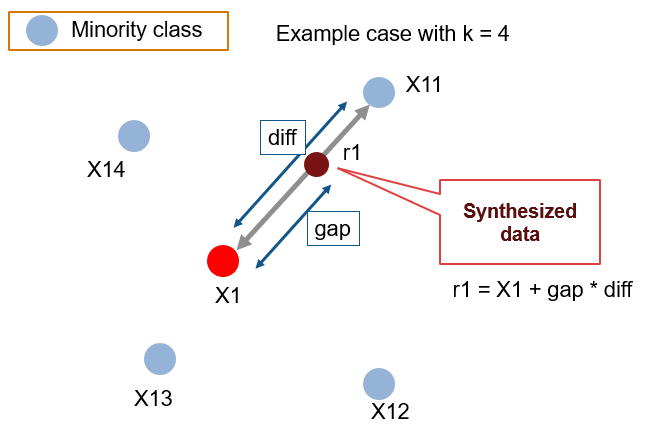


Though this algorithm is quite useful, it has few drawbacks associated with it.

+ i) The synthetic instances generated are in the same direction i.e. connected by an artificial line its diagonal instances. This in turn complicates the decision surface generated by few classifier algorithms.

+ ii) SMOTE tends to create a large no. of noisy data points in feature space.

In [119]:
x = model_data.drop(['taxable_category'], axis=1)
y = model_data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [120]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


### 7.1 SMOTE Oversampling technique<a class="anchor" id="7.1"></a> 

In [129]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Check the class distribution before oversampling
counter = Counter(y_train)
print('Before', counter)

# Step 2: Oversample the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

# Step 3: Check the class distribution after oversampling
counter = Counter(y_train_sm)
print('After', counter)


Before Counter({0: 382, 1: 98})
After Counter({0: 382, 1: 382})


In [130]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 382, 1: 98})
After Counter({0: 382, 1: 382})


### 7.2 ADASYN: Adaptive Synthetic Sampling Approach<a class="anchor" id="7.2"></a> 
ADASYN is a generalized form of the SMOTE algorithm. This algorithm also aims to oversample the minority class by generating synthetic instances for it. But the difference here is it considers the density distribution, ri which decides the no. of synthetic instances generated for samples which difficult to learn. Due to this, it helps in adaptively changing the decision boundaries based on the samples difficult to learn. This is the major difference compared to SMOTE.

<b>Working Procedure</b>:
From the dataset, the total no. of majority N– and minority N+ are captured respectively. Then we preset the threshold value, dth for the maximum degree of class imbalance. Total no. of synthetic samples to be generated, G = (N– – N+) x β. Here, β = (N+/ N–).\
For every minority sample xi, KNN’s are obtained using Euclidean distance, and ratio ri is calculated as Δi/k and further normalized as rx <= ri / ∑ rᵢ .\
Thereafter, the total synthetic samples for each xi will be, gi = rx x G. Now we iterate from 1 to gi to generate samples the same way as we did in SMOTE.\
The below-given diagram represents the above procedure:

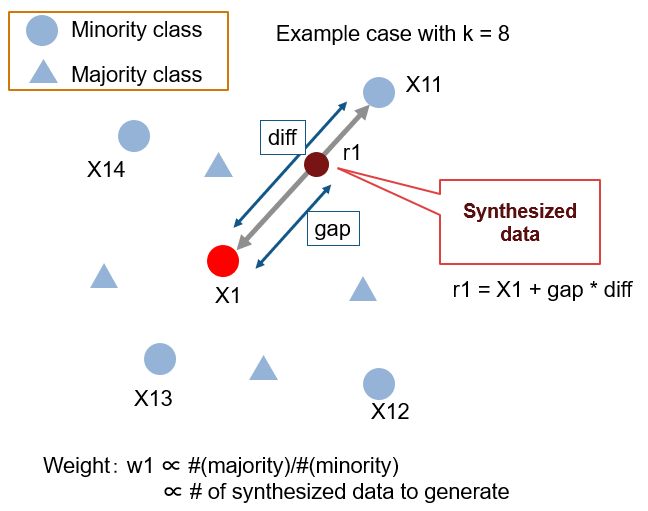

In [131]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 382, 1: 98})
After Counter({1: 394, 0: 382})


### 7.3 Hybridization: SMOTE + Tomek Links<a class="anchor" id="7.3"></a> 
Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.

SMOTE+TOMEK is such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space. After the oversampling is done by SMOTE, the class clusters may be invading each other’s space. As a result, the classifier model will be overfitting. Now, Tomek links are the opposite class paired samples that are the closest neighbors to each other. Therefore the majority of class observations from these links are removed as it is believed to increase the class separation near the decision boundaries. Now, to get better class clusters, Tomek links are applied to oversampled minority class samples done by SMOTE. Thus instead of removing the observations only from the majority class, we generally remove both the class observations from the Tomek links

[Table of Contents](#0.1)

In [132]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 382, 1: 98})
After Counter({0: 288, 1: 288})


### 7.4 Hybridization: SMOTE + ENN<a class="anchor" id="7.4"></a> 
SMOTE + ENN is another hybrid technique where more no. of observations are removed from the sample space. Here, ENN is yet another undersampling technique where the nearest neighbors of each of the majority class is estimated. If the nearest neighbors misclassify that particular instance of the majority class, then that instance gets deleted.

Integrating this technique with oversampled data done by SMOTE helps in doing extensive data cleaning. Here on misclassification by NN’s samples from both the classes are removed. This results in a more clear and concise class separation.

<b>Python Code for SMOTE + ENN algorithm:

In [133]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 382, 1: 98})
After Counter({1: 114, 0: 111})


##### The below-given picture shows how different SMOTE based resampling techniques work out to deal with imbalanced data.

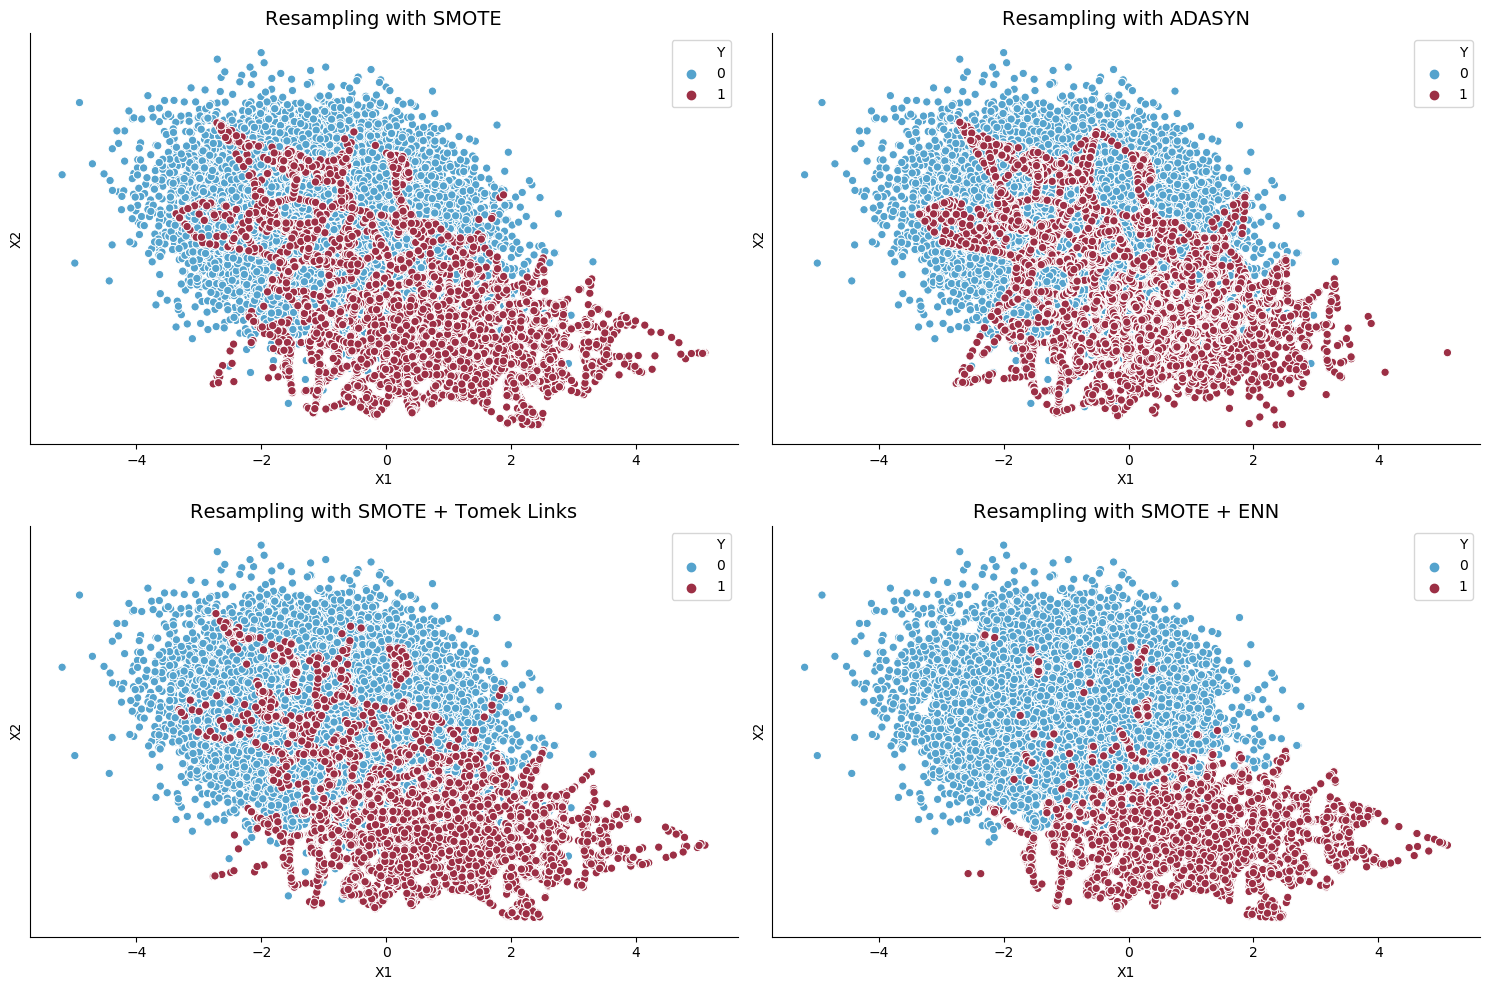

[Table of Contents](#0.1)

### 7.5 Performance Analysis after Resampling<a class="anchor" id="7.5"></a> 

In [134]:
sampled_data = {
    'ACTUAL':[x_train, y_train],
    'SMOTE':[x_train_sm, y_train_sm],
    'ADASYN':[x_train_ada, y_train_ada],
    'SMOTE_TOMEK':[x_train_smtom, y_train_smtom],
    'SMOTE_ENN':[x_train_smenn, y_train_smenn]
}

In [135]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    #plot_confusion_matrix(clf_model, X_test, y_test)  
    #plt.show() 
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    #print('AUC-ROC')
    #print('='*60)
    #print(roc_auc_score(y_test, y_prob[:,1], multi_class='ovo'))
    
    #x = roc_auc_score(y_test, y_prob[:,1])
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [136]:
model_params = {

    'random-forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
             "n_estimators": [5, 10, 15, 20, 25], 
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']

         }
    }
}

In [139]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score


cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1 )
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print('x'*60)
        print(model+' with ' + resam)
        print('='*60)
        output.append(test_eval(clf_best, x_test, y_test, model, resam))

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with ACTUAL
Confusion Matrix
[[94  0]
 [26  0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        94
           1       0.00      0.00      0.00        26

    accuracy                           0.78       120
   macro avg       0.39      0.50      0.44       120
weighted avg       0.61      0.78      0.69       120
 



C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with SMOTE
Confusion Matrix
[[91  3]
 [25  1]] 

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        94
           1       0.25      0.04      0.07        26

    accuracy                           0.77       120
   macro avg       0.52      0.50      0.47       120
weighted avg       0.67      0.77      0.69       120
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
random-forest with ADASYN
Confusion Matrix
[[87  7]
 [26  0]] 

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        94
           1       0.00      0.00      0.00        26

    accuracy                           0.73       120
   macro avg       0.38      0.46      0.42       120
weighted avg       0.60      0.72      0.66       120
 

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

#### As the results can be compared, ADASYN technique gave the best results we are going to use it further 

In [140]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 382, 1: 98})
After Counter({1: 394, 0: 382})


In [141]:
x_train,x_test,y_train,y_test = train_test_split(x_train_ada,y_train_ada,test_size=0.3,random_state=0, stratify=y_train_ada)

counter = Counter(y_train)
print('Train',counter)
counter = Counter(y_test)
print('Test',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Train Counter({1: 276, 0: 267})
Test Counter({1: 118, 0: 115})
Shape of X_train:  (543, 16)
Shape of X_test:  (233, 16)
Shape of y_train:  (543,)
Shape of y_test (233,)


[Table of Contents](#0.1)

## 8. Random Forest<a class="anchor" id="8"></a> 
Random Forest is one of the most popular and most powerful machine learning algorithms. It is a type of ensemble machine learning algorithm called Bootstrap Aggregation or bagging.
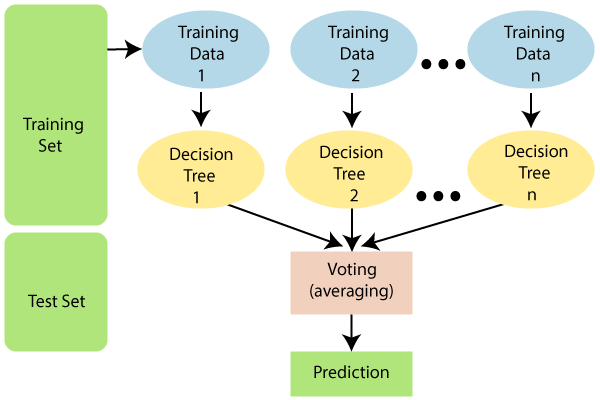
To improve performance of Decision trees, we can use many trees with a random sample of features chosen as the split.

####  Bagging
Bagging, also known as Bootstrap Aggregation is the ensemble technique used by random forest. Bagging chooses a random sample from the data set. Hence each model is generated from the samples (Bootstrap Samples) provided by the Original Data with replacement known as row sampling. This step of row sampling with replacement is called bootstrap. Now each model is trained independently which generates results. The final output is based on majority voting after combining the results of all models. This step which involves combining all the results and generating output based on majority voting is known as aggregation.
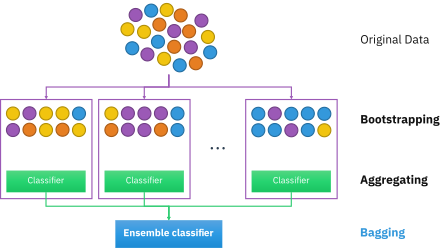

####  Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

- **Random forest algorithm parameters:**
- `n_estimators`: The number of trees in the forest.
*** 
- `criterion`: The function to measure the quality of a split. Supported criteria are "`gini`" for the Gini impurity and "`entropy`" for the information gain.
***
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
***
- `min_samples_split`: The minimum number of samples required to split an internal node.
***
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least ``min_samples_leaf`` training samples in each of the left and right branches.  This may have the effect of smoothing the model, especially in regression.
***
- `min_weight_fraction_leaf`: The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
***
- `max_features`: The number of features to consider when looking for the best split.
***
- `max_leaf_nodes`: Grow a tree with ``max_leaf_nodes`` in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
***
- `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
***
- `min_impurity_split`: Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
***
- `bootstrap`: Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.
***
- `oob_score`: Whether to use out-of-bag samples to estimate the generalization accuracy.

### 8.1 Random Forest hyperparameter tuning<a class="anchor" id="8.1"></a> 


In [142]:
#base model
score_array = []
for each in range(1,200):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_test,y_test))

In [143]:
loc = np.array(score_array).max()
score_array.index(loc)+1

81

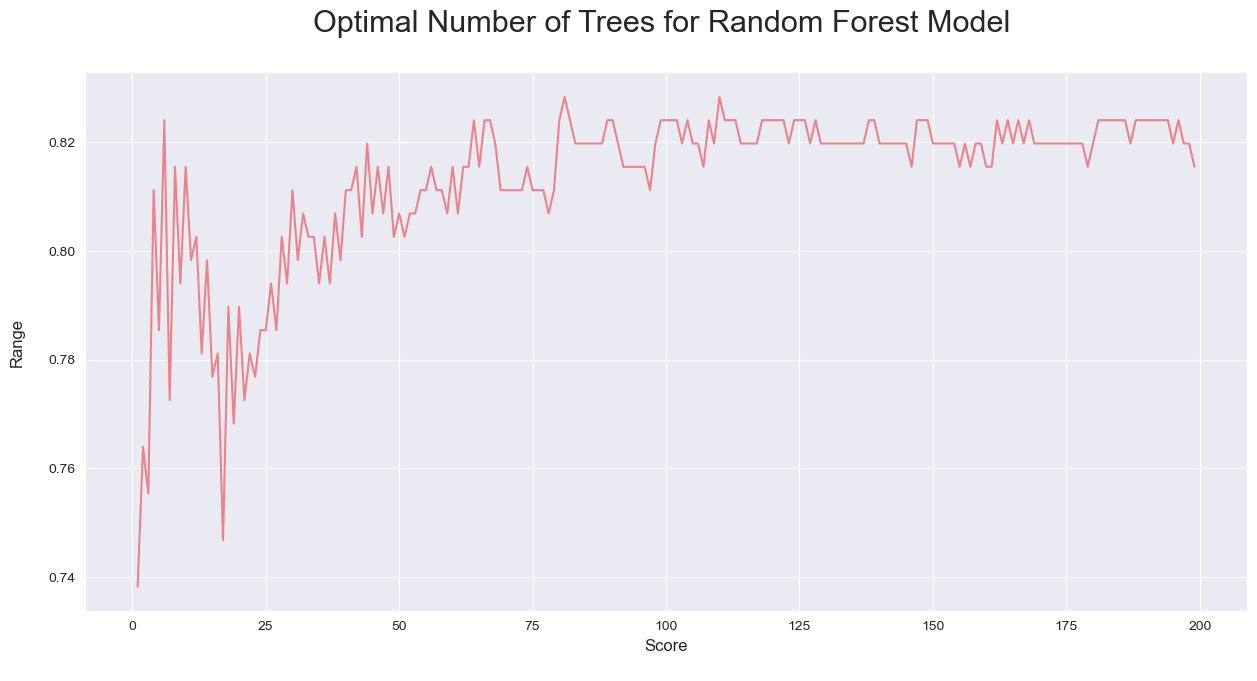

In [144]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

#### a) Randomized Search Cross Validation<a class="anchor" id="a"></a> 

In [145]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train, y_train)

print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best paramters: {'n_estimators': 90, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True})
Train Result:
Accuracy Score: 95.40%
_______________________________________________
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       267
           1       0.99      0.92      0.95       276

    accuracy                           0.95       543
   macro avg       0.96      0.95      0.95       543
weighted avg       0.96      0.95      0.95       543

_______________________________________________
Confusion Matrix:
 [[264   3]
 [ 22 254]]

Test Result:
Accuracy Score: 82.40%
_______________________________________________
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       115
           1       0.85      0.79      0.82       118

    accuracy                           0.82       233
   m

#### `Random search` allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with `GridSearchCV`, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define

#### b) Grid Search Cross Validation<a class="anchor" id="b"></a> 

In [146]:
# Create a pipeline with a Random forest classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from time import time
    
pipe_rfc = Pipeline([ 
                      ('scl', StandardScaler()), 
                    ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )])

# Set the grid parameters
param_grid_rfc =  [ {
    'rfc__n_estimators': [100, 200,300,400], # number of estimators
    #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
    'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
    'rfc__max_depth': [None, 5], # Max depth of the trees
    'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
    }]
# Use 10 fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

#Fit the pipeline
start = time()
grid_rfc = grid_rfc.fit(x_train, y_train)
end = time()

print("RFC grid search took %.3f seconds" %(end-start))

# Best score and best parameters
print('-------Best score----------')
print(grid_rfc.best_score_ * 100.0)
print('-------Best params----------')
print(grid_rfc.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
RFC grid search took 62.315 seconds
-------Best score----------
80.70555904113854
-------Best params----------
{'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.01, 'rfc__n_estimators': 200}


### 8.2 Visualizing one of the decision tree in random forest<a class="anchor" id="8.2"></a> 

In [147]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(max_depth=20, max_features='auto', min_samples_split=5,
                       n_estimators=90, random_state=42)

In [148]:
df1.taxable_category.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

[Table of Contents](#0.1)

## 9. Applications of Random Forest<a class="anchor" id="9"></a> 
### There are mainly four sectors where Random forest mostly used:

+ ### Banking: Banking sector mostly uses this algorithm for the identification of loan risk.
+ ### Medicine: With the help of this algorithm, disease trends and risks of the disease can be identified.
+ ### Land Use: We can identify the areas of similar land use by this algorithm.
+ ### Marketing: Marketing trends can be identified using this algorithm.

### 9.2 Disadvantages of Random Forest<a class="anchor" id="9.2"></a> 
+ #### 1. Random forest is highly complex when compared to decision trees where decisions can be made by following the path of the tree.

+ #### 2. Training time is more compared to other models due to its complexity. Whenever it has to make a prediction each decision tree has to generate output for the given input data.

+ #### 3. Although random forest can be used for both classification and regression tasks, it is not more suitable for Regression tasks.

# 10. Summary<a class="anchor" id="10"></a> 
In this notebook we learned the following lessons:
- Random forest algorithm and the parameters of each algorithm.
- How to tune hyperparameters for Random Forest.
- Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. 
  - By sampling an equal number of samples from each class  
  - By normalizing the sum of the sample weights (sample_weight) for each class to the same value. 

  
## References:
- [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
- [Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)
- [Bagging and Random Forest Ensemble Algorithms for Machine Learning](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/)